# Model-Independent Pricing of FX Exotics using Optimal Transport

## Required Packages & Call Option Data

In [18]:
import src.svi_lib as svi_lib
import src.ot_lib as ot_lib
import src.black_lib as bs_lib
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.stats import linregress
from tabulate import tabulate

#Maturity for data
T=1/12

#EUR/USD call prices (strikes against observed implied volatilities)
X_strikes = np.array([1.0681,1.0791,1.0904,1.1014,1.1119])
X_market_vols = np.array([0.0554,0.053115,0.0516,0.051435,0.0523])
X_market_prices=np.zeros(len(X_strikes))
X_forw=1.0903

X_norm=X_strikes/X_forw
X_strikes_lognrm = np.log(X_norm)
X_market_prices=np.zeros(len(X_strikes))

#GBP/USD call prices (strikes against observed implied volatilities)
Y_strikes = np.array([1.2456,1.2595,1.274,1.2883,1.3017])
Y_market_vols = np.array([0.06055,0.058665,0.0573,0.057185,0.05765])
Y_forw=1.2738
Y_norm=Y_strikes/Y_forw
Y_strikes_lognrm = np.log(Y_norm)
Y_market_prices=np.zeros(len(Y_strikes))
    
#EUR/GBP call prices (strikes against observed implied volatilities)
Z_strikes = np.array([0.84386,0.84969,0.85585,0.86234,0.86875])
Z_market_vols = np.array([0.03809,0.03725,0.037225,0.03825,0.03986])
Z_forw=0.8559
Z_norm=Z_strikes/Z_forw
Z_strikes_lognrm = np.log(Z_norm)
Z_market_prices=np.zeros(len(Z_strikes))

#Calculation of Market Prices
for i in range(len(X_strikes)):
    X_market_prices[i]=bs_lib.black_scholes_call(X_forw, X_strikes[i], T, X_market_vols[i])
    Y_market_prices[i]=bs_lib.black_scholes_call(Y_forw, Y_strikes[i], T, Y_market_vols[i])
    Z_market_prices[i]=bs_lib.black_scholes_call(Z_forw, Z_strikes[i], T, Z_market_vols[i])

## Task 1: Deriving Marginal Densities from SVI parameterisations

### Fitting SVI curves with convex optimisation

In [13]:
#Fitting the correct parameters for a curve using the Scipy optimiser
Xopt = svi_lib.svi_fit(X_strikes_lognrm,X_market_vols,[0.0001, 0.002, 0.0014, 0, 0.005],T)
Yopt = svi_lib.svi_fit(Y_strikes_lognrm,Y_market_vols,[0.0001, 0.002, 0.0014, 0, 0.005],T)
Zopt = svi_lib.svi_fit(Z_strikes_lognrm,Z_market_vols,[0.00001, 0.0005, 0.001, 0, 0.0],T)

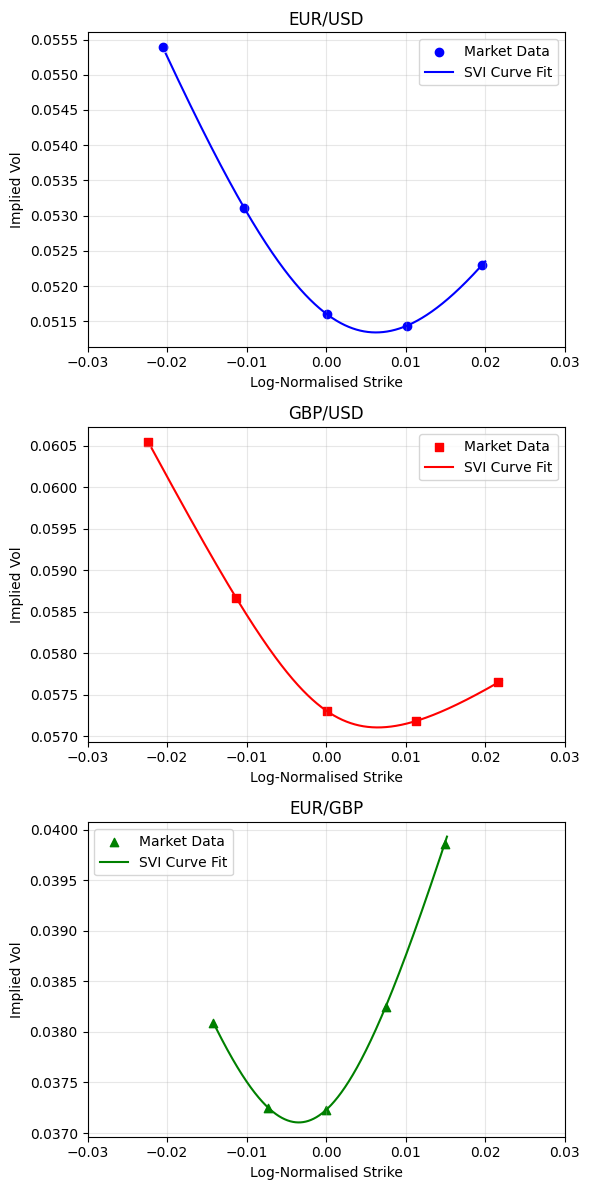

In [19]:
#Demonstration of the alignment between market data and the interpolating SVI curve
def demo_svi_fit(X_strikes_lognrm,Y_strikes_lognrm,Z_strikes_lognrm,Xopt,Yopt,Zopt,T):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12))
    X_strike_range = np.linspace(0.98*min(X_strikes_lognrm), 1.02*max(X_strikes_lognrm), 1000)
    Y_strike_range = np.linspace(0.98*min(Y_strikes_lognrm), 1.02*max(Y_strikes_lognrm), 1000)
    Z_strike_range = np.linspace(0.98*min(Z_strikes_lognrm), 1.02*max(Z_strikes_lognrm), 1000)


    ax1.scatter(X_strikes_lognrm, X_market_vols, label='Market Data', color='blue', marker='o')
    ax1.plot(X_strike_range, svi_lib.svi_vol(X_strike_range, Xopt.x,T), 'b-', label='SVI Curve Fit')
    ax1.set_title('EUR/USD')
    ax1.set_ylabel('Implied Vol')
    ax1.set_xlabel('Log-Normalised Strike')
    ax1.set_xlim(-0.03,0.03)
    ax1.grid(True, alpha=0.3)

    ax2.scatter(Y_strikes_lognrm, Y_market_vols, label='Market Data', color='red', marker='s')
    ax2.plot(Y_strike_range, svi_lib.svi_vol(Y_strike_range, Yopt.x,T), 'r-', label='SVI Curve Fit')
    ax2.set_title('GBP/USD')
    ax2.set_xlabel('Log-Normalised Strike')
    ax2.set_ylabel('Implied Vol')
    ax2.set_xlim(-0.03,0.03)
    ax2.grid(True, alpha=0.3)

    ax3.scatter(Z_strikes_lognrm, Z_market_vols, label='Market Data', color='green', marker='^')
    ax3.plot(Z_strike_range, svi_lib.svi_vol(Z_strike_range, Zopt.x,T), 'g-', label='SVI Curve Fit')
    ax3.set_title('EUR/GBP')
    ax3.set_xlim(-0.03,0.03)
    ax3.set_xlabel('Log-Normalised Strike')
    ax3.set_ylabel('Implied Vol')
    ax3.grid(True, alpha=0.3)

    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.tight_layout()
    plt.show()
    return

demo_svi_fit(X_strikes_lognrm,Y_strikes_lognrm,Z_strikes_lognrm,Xopt,Yopt,Zopt,T)

### Inference of Density by Breeden-Litzenberger

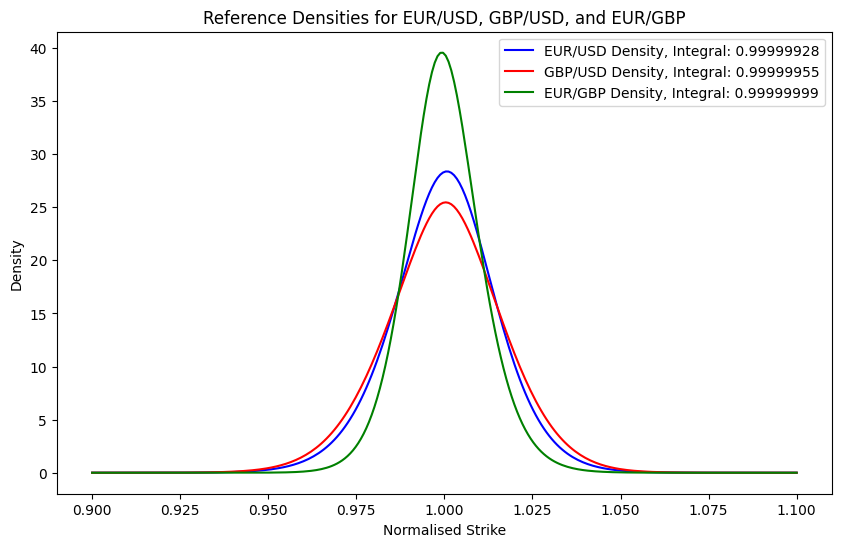

In [20]:
#Construction of the reference densities from the SVI curves for X,Y,Z
def mu_X(xvar):
    return svi_lib.SVIDensity(xvar,Xopt.x)

def mu_Y(yvar):
    return svi_lib.SVIDensity(yvar,Yopt.x)

def mu_Z(zvar):
    return svi_lib.SVIDensity(zvar,Zopt.x)

#An ansatz in Gibbs form for joint density which we will later optimise using the functions u,v,w
def opt_mu(x,y, u_spline, v_spline, w_spline):
    return np.exp(u_spline(x)+v_spline(y)+y*w_spline(x/y))*mu_X(x)*mu_Y(y)

def demo_BL_density(quadgrid,quadweights,mu_X,mu_Y,mu_Z):
    #plot mu_X. Y  Z densities with integral values of annotated
    integral_X = np.sum(mu_X(quadgrid) * quadweights)
    integral_Y = np.sum(mu_Y(quadgrid) * quadweights)
    integral_Z = np.sum(mu_Z(quadgrid) * quadweights)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(quadgrid, mu_X(quadgrid), label='EUR/USD Density, Integral: '+str(round(integral_X,8)), color='blue')
    ax.plot(quadgrid, mu_Y(quadgrid), label='GBP/USD Density, Integral: '+str(round(integral_Y,8)), color='red')
    ax.plot(quadgrid, mu_Z(quadgrid), label='EUR/GBP Density, Integral: '+str(round(integral_Z,8)), color='green')

    ax.set_title('Reference Densities for EUR/USD, GBP/USD, and EUR/GBP')
    ax.set_xlabel('Normalised Strike')
    ax.set_ylabel('Density')
    ax.legend()
    plt.show()
    return

#Setup of Gaussian Quadrature for integration of densities
quadPoints = 400
[u, w] = np.polynomial.legendre.leggauss(quadPoints)
a = 0.9
b = 1.1
quadgrid = 0.5*(b-a)*u + 0.5*(a+b)
quadweights = 0.5*(b-a)*w

demo_BL_density(quadgrid,quadweights,mu_X,mu_Y,mu_Z)

### Test: pricing via densities agrees with market data
The curves on the plot below are the SVI parameterisations of implied volatility which we fit to the original market data. The black points are the implied volatilities corresponding to call call option prices calculated using the reference densities above. As we see the points coincide with the market curve meaning indicating that the densities are effective for pricing.

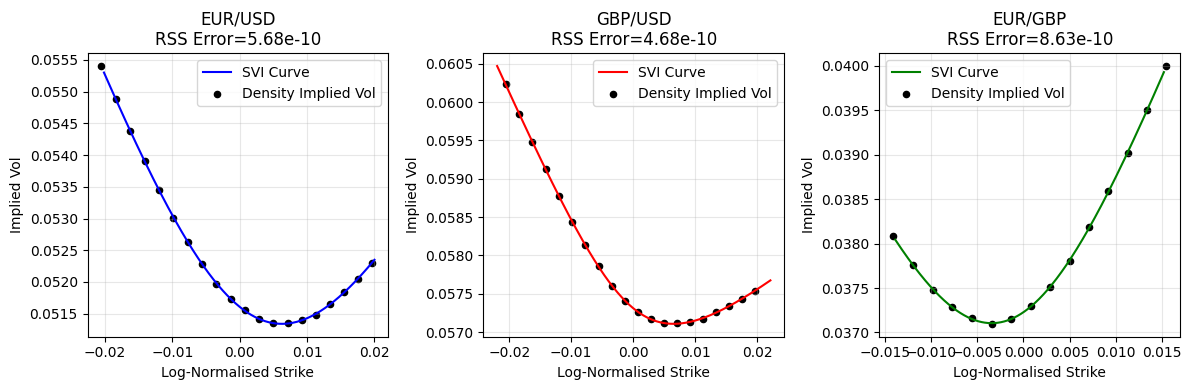

PRICE OF AT THE MONEY CALL USING REF DENSITIES
++++++++++++++++++++++++++++++++++++++++++++++++
Pair            Density Price    Market BS Price   Difference
------------------------------------------------------------
EUR/USD            0.00648080         0.00648003     7.74e-07
GBP/USD            0.00840797         0.00840715     8.24e-07
EUR/GBP            0.00367046         0.00366959     8.65e-07


In [21]:
#Payoff function for a call option
simple_call=lambda x,k: np.maximum(0,x-k)
#Testing the desnities for X,Y,Z by pricing options at the observed strike and checking results match market data

def demo_1D_density_pricing(X_norm, X_strikes_lognrm, Y_strikes_lognrm, Z_strikes_lognrm, X_forw, Y_forw, Z_forw, T, quadgrid, quadweights, mu_X, mu_Y, mu_Z, Xopt, Yopt, Zopt, simple_call):
    strikes = np.linspace(X_norm[0],X_norm[-1],20)

    X_strike_range = np.linspace(0.98*min(X_strikes_lognrm), 1.02*max(X_strikes_lognrm), 1000)
    Y_strike_range = np.linspace(0.98*min(Y_strikes_lognrm), 1.02*max(Y_strikes_lognrm), 1000)
    Z_strike_range = np.linspace(0.98*min(Z_strikes_lognrm), 1.02*max(Z_strikes_lognrm), 1000)

    density_price_X=np.zeros_like(strikes)
    density_price_Y=np.zeros_like(strikes)
    density_price_Z=np.zeros_like(strikes)

    for i in range(len(strikes)):
        #Integration via GQ to price simple options on X,Y,Z
        density_price_X[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_X(quadgrid) * quadweights)*X_forw
        density_price_Y[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_Y(quadgrid) * quadweights)*Y_forw
        density_price_Z[i] = np.sum(simple_call(quadgrid,strikes[i])*mu_Z(quadgrid) * quadweights)*Z_forw

    #Conversion from price to implied vol using BS for comparison against the market derived SVI
    density_vol_X = [bs_lib.implied_vol(X_forw, strikes[i]*X_forw, T, density_price_X[i]) for i in range(len(strikes))]
    density_vol_Y = [bs_lib.implied_vol(Y_forw, strikes[i]*Y_forw, T, density_price_Y[i]) for i in range(len(strikes))]
    density_vol_Z = [bs_lib.implied_vol(Z_forw, strikes[i]*Z_forw, T, density_price_Z[i]) for i in range(len(strikes))]

    # Plot: Implied vol from density price (scatter) vs SVI curve (line) with more density points
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    # Calculate SVI vol at the density-implied vol points
    svi_vol_X_points = svi_lib.svi_vol(np.log(strikes), Xopt.x, T)
    svi_vol_Y_points = svi_lib.svi_vol(np.log(strikes), Yopt.x, T)
    svi_vol_Z_points = svi_lib.svi_vol(np.log(strikes), Zopt.x, T)
    # Calculate RSS errors
    rss_X = np.sum((np.array(density_vol_X) - svi_vol_X_points)**2)
    rss_Y = np.sum((np.array(density_vol_Y) - svi_vol_Y_points)**2)
    rss_Z = np.sum((np.array(density_vol_Z) - svi_vol_Z_points)**2)

    # EUR/USD
    ax1.plot(X_strike_range, svi_lib.svi_vol(X_strike_range, Xopt.x, T), 'b-', label='SVI Curve')
    ax1.scatter(np.log(strikes), density_vol_X, label='Density Implied Vol', color='black', marker='o', s=20)
    ax1.set_title(f'EUR/USD\nRSS Error={rss_X:.2e}')
    ax1.set_ylabel('Implied Vol')
    ax1.set_xlabel('Log-Normalised Strike')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # GBP/USD
    ax2.plot(Y_strike_range, svi_lib.svi_vol(Y_strike_range, Yopt.x, T), 'r-', label='SVI Curve')
    ax2.scatter(np.log(strikes), density_vol_Y, label='Density Implied Vol', color='black', marker='o', s=20)
    ax2.set_title(f'GBP/USD\nRSS Error={rss_Y:.2e}')
    ax2.set_xlabel('Log-Normalised Strike')
    ax2.set_ylabel('Implied Vol')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # EUR/GBP
    ax3.plot(Z_strike_range, svi_lib.svi_vol(Z_strike_range, Zopt.x, T), 'g-', label='SVI Curve')
    ax3.scatter(np.log(strikes[3:-2]), density_vol_Z[3:-2], label='Density Implied Vol', color='black', marker='o', s=20)
    # For RSS, use the same subset as plotted
    rss_Z_plot = np.sum((np.array(density_vol_Z[3:-2]) - svi_vol_Z_points[3:-2])**2)
    ax3.set_title(f'EUR/GBP\nRSS Error={rss_Z_plot:.2e}')
    ax3.set_xlabel('Log-Normalised Strike')
    ax3.set_ylabel('Implied Vol')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    #Gaussian Quadrature to integrate payoff of an option with normalised strike 1 (i.e. an call with strike = Forward price)
    density_price_X_atm = np.sum(simple_call(quadgrid, 1) * mu_X(quadgrid) * quadweights) * X_forw
    market_price_X_atm = bs_lib.black_scholes_call(X_forw, X_forw, T, svi_lib.svi_vol(0, Xopt.x, T))

    density_price_Y_atm = np.sum(simple_call(quadgrid, 1) * mu_Y(quadgrid) * quadweights) * Y_forw
    market_price_Y_atm = bs_lib.black_scholes_call(Y_forw, Y_forw, T, svi_lib.svi_vol(0, Yopt.x, T))

    density_price_Z_atm = np.sum(simple_call(quadgrid, 1) * mu_Z(quadgrid) * quadweights) * Z_forw
    market_price_Z_atm = bs_lib.black_scholes_call(Z_forw, Z_forw, T, svi_lib.svi_vol(0, Zopt.x, T))

    print("PRICE OF AT THE MONEY CALL USING REF DENSITIES")
    print("++++++++++++++++++++++++++++++++++++++++++++++++")
    print(f"{'Pair':<10} {'Density Price':>18} {'Market BS Price':>18} {'Difference':>12}")
    print("-" * 60)
    print(f"{'EUR/USD':<10} {density_price_X_atm:18.8f} {market_price_X_atm:18.8f} {(density_price_X_atm-market_price_X_atm):12.2e}")
    print(f"{'GBP/USD':<10} {density_price_Y_atm:18.8f} {market_price_Y_atm:18.8f} {(density_price_Y_atm-market_price_Y_atm):12.2e}")
    print(f"{'EUR/GBP':<10} {density_price_Z_atm:18.8f} {market_price_Z_atm:18.8f} {(density_price_Z_atm-market_price_Z_atm):12.2e}")
    return

demo_1D_density_pricing(X_norm, X_strikes_lognrm, Y_strikes_lognrm, Z_strikes_lognrm, X_forw, Y_forw, Z_forw, T, quadgrid, quadweights, mu_X, mu_Y, mu_Z, Xopt, Yopt, Zopt, simple_call)


## Task 2: Calibrating a joint density to all three marginals
We now wish to price more exotic derivatives that depend on the joint distribution of X and Y. We use an optimal transport method (Sinkhorn Algorithm) to calibrate a density conforming to the three curves we have observed.

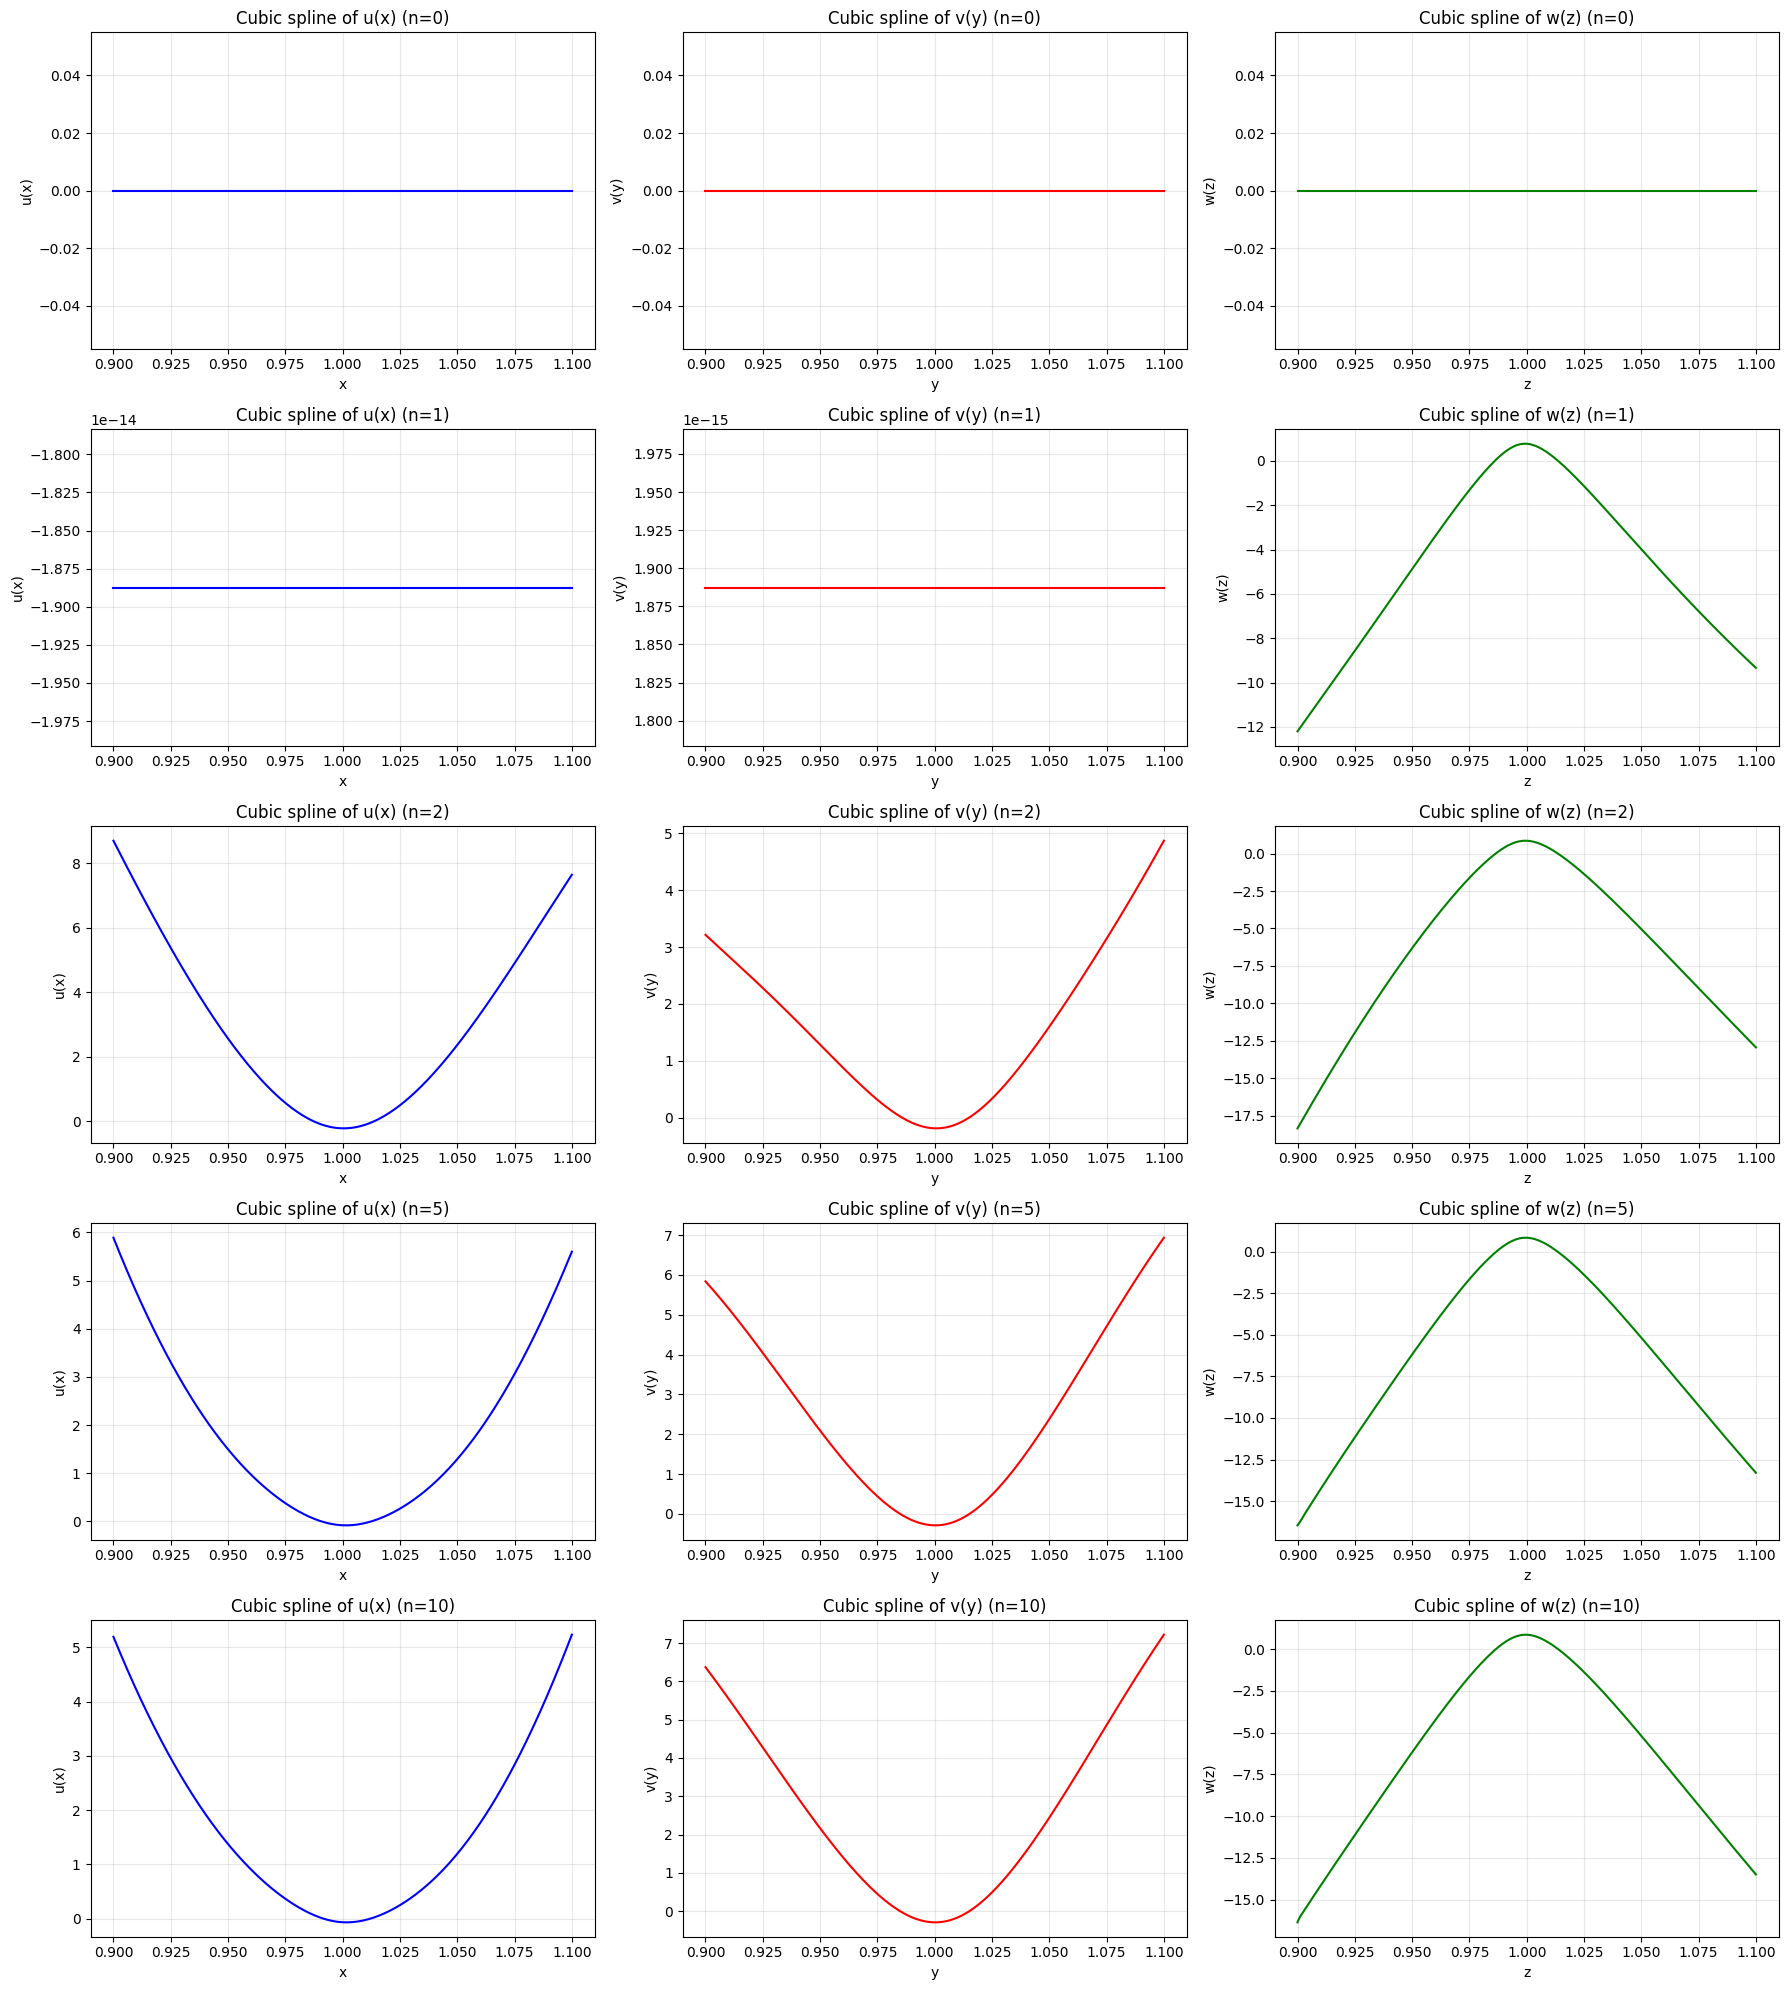

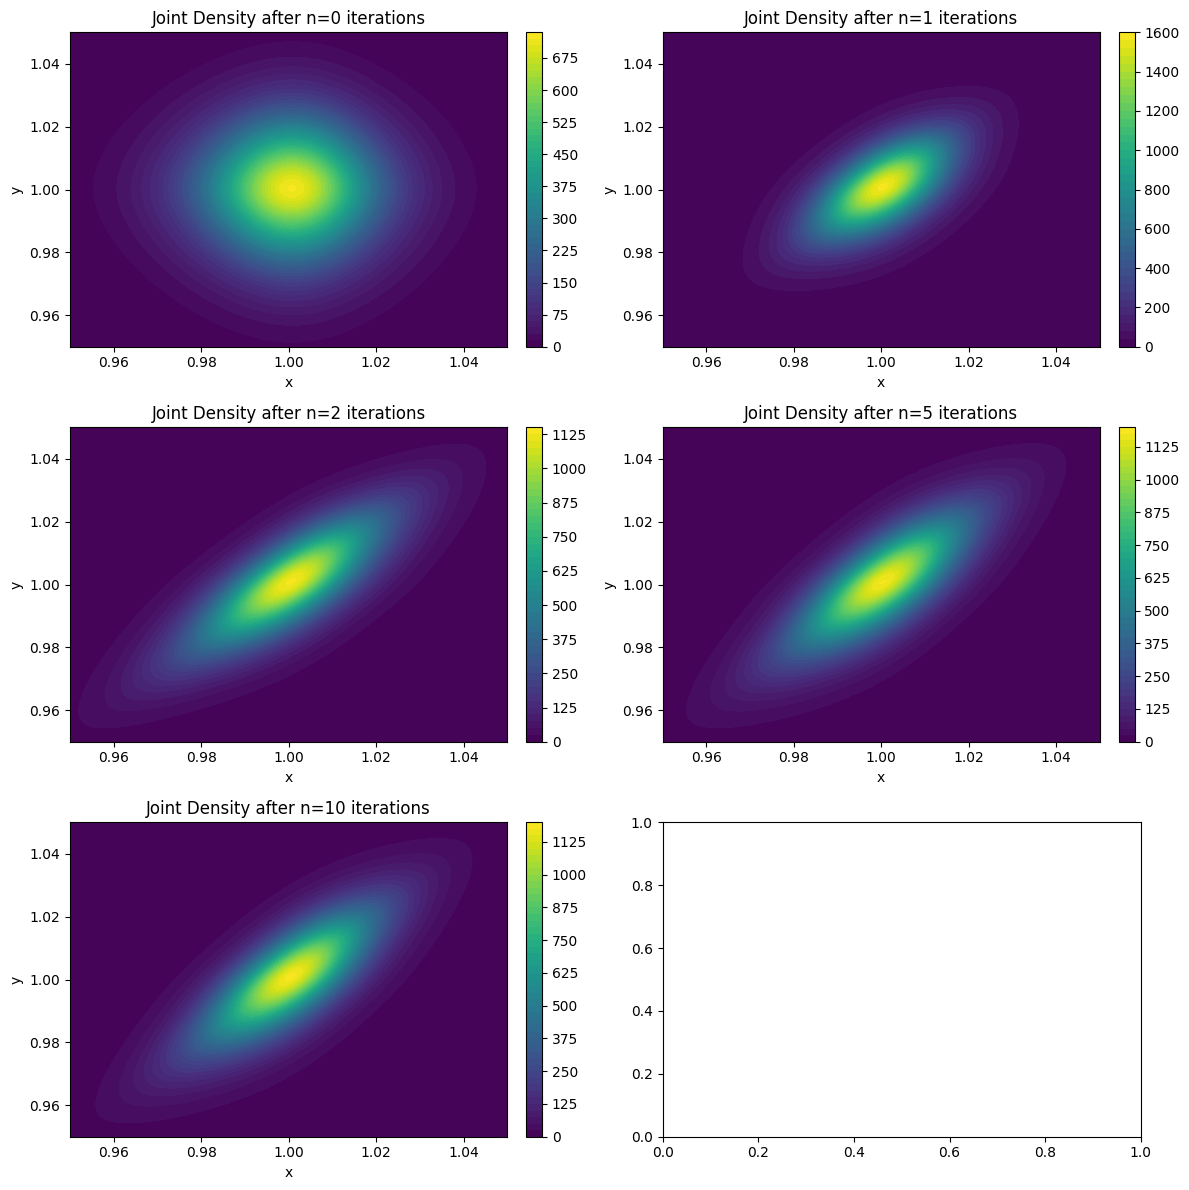

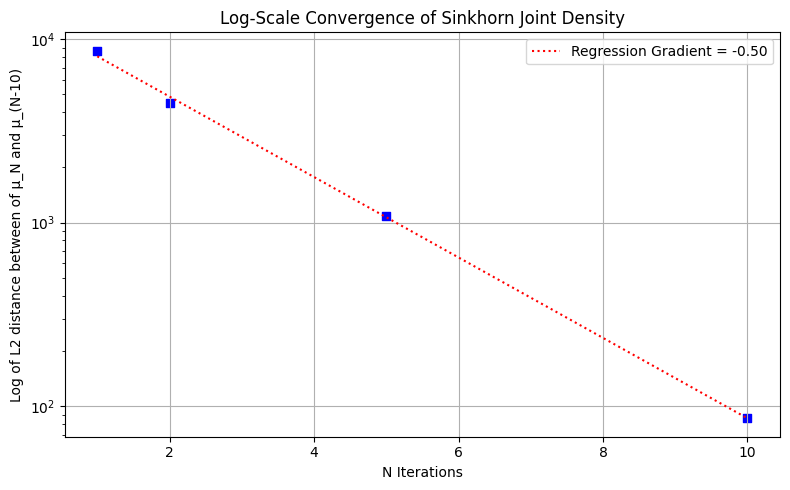

In [22]:
#Grid for use in sinkhorn calibration
sinkPoints = 400
[u_s, w_s] = np.polynomial.legendre.leggauss(sinkPoints)
a_s = 0.8
b_s = 1.2
sinkgrid = 0.5*(b_s-a_s)*u_s + 0.5*(a_s+b_s)
sinkweights = 0.5*(b_s-a_s)*w_s
z_points = np.linspace(np.min(sinkgrid)/np.max(sinkgrid), np.max(sinkgrid)/np.min(sinkgrid), len(sinkgrid))

#Grid for use in plotting and integration
quadPoints = 400
[u, w] = np.polynomial.legendre.leggauss(quadPoints)
a = 0.9
b = 1.1
quadgrid = 0.5*(b-a)*u + 0.5*(a+b)
quadweights = 0.5*(b-a)*w

iterations_list = [0,1,2,5,10]

def demo_spline_evolution(sinkgrid, sinkweights, z_points, quadgrid, iterations_list):
    """
    Generates and plots the evolution of u_x, v_y, and w_z splines produced by sinkhorn
    """
    fig, axes = plt.subplots(len(iterations_list), 3, figsize=(18, 4 * len(iterations_list)))
    # Ensure axes is always 2D
    if len(iterations_list) == 1:
        axes = np.array([axes])

    for row_idx, n_iter in enumerate(iterations_list):
        # Calculate optimal u, v, w for the current iteration
        opt_u, opt_v, opt_w = ot_lib.sinkhorn(sinkgrid,sinkweights,mu_X,mu_Y,mu_Z,n_iter)

        # Create CubicSplines
        u_spline = CubicSpline(sinkgrid, opt_u)
        v_spline = CubicSpline(sinkgrid, opt_v)
        w_spline = CubicSpline(z_points, opt_w)

        # Column 1: u_x
        ax_u = axes[row_idx, 0]
        ax_u.plot(quadgrid, u_spline(quadgrid), color='blue')
        ax_u.set_title(f'Cubic spline of u(x) (n={n_iter})')
        ax_u.set_xlabel('x')
        ax_u.set_ylabel('u(x)')
        ax_u.grid(True, alpha=0.3)

        # Column 2: v_y
        ax_v = axes[row_idx, 1]
        ax_v.plot(quadgrid, v_spline(quadgrid), color='red')
        ax_v.set_title(f'Cubic spline of v(y) (n={n_iter})')
        ax_v.set_xlabel('y')
        ax_v.set_ylabel('v(y)')
        ax_v.grid(True, alpha=0.3)

        # Column 3: w_z spline
        ax_w = axes[row_idx, 2]
        ax_w.plot(quadgrid, w_spline(quadgrid), color='green')
        ax_w.set_title(f'Cubic spline of w(z) (n={n_iter})')
        ax_w.set_xlabel('z')
        ax_w.set_ylabel('w(z)')
        ax_w.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return

def demo_density_evolution(sinkgrid, sinkweights, z_points, quadgrid, iterations_list):
    n_plots = len(iterations_list)
    n_rows = (n_plots + 1) // 2  # Round up for odd numbers
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))  # 3 rows, 2 columns
    for idx, n_iter in enumerate(iterations_list):
        row, col = divmod(idx, 2)
        ax_c = axes[row][col]

        opt_u, opt_v, opt_w = ot_lib.sinkhorn(sinkgrid, sinkweights, mu_X, mu_Y, mu_Z, n_iter)
        u_spline = CubicSpline(sinkgrid, opt_u)
        v_spline = CubicSpline(sinkgrid, opt_v)
        w_spline = CubicSpline(z_points, opt_w)

        X, Y = np.meshgrid(quadgrid, quadgrid)
        Z = opt_mu(X, Y, u_spline, v_spline, w_spline)
        contour = ax_c.contourf(X, Y, Z, levels=50, cmap='viridis')
        ax_c.set_title(f'Joint Density after n={n_iter} iterations')
        ax_c.set_xlabel('x')
        ax_c.set_ylabel('y')
        ax_c.set_xlim(0.95, 1.05)
        ax_c.set_ylim(0.95, 1.05)
        plt.colorbar(contour, ax=ax_c, orientation='vertical', fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    return

def demo_convergence(sinkgrid, sinkweights, z_points, quadgrid, iterations_list):
    prev_density = None
    density_diffs = []
    X, Y = np.meshgrid(sinkgrid, sinkgrid)

    for n_iter in iterations_list:
        opt_u, opt_v, opt_w = ot_lib.sinkhorn(sinkgrid, sinkweights, mu_X, mu_Y, mu_Z, n_iter)
        # Reconstruct splines
        u_spline = CubicSpline(sinkgrid, opt_u)
        v_spline = CubicSpline(sinkgrid, opt_v)
        w_spline = CubicSpline(z_points, opt_w)
        # Evaluate the joint density
        current_density = opt_mu(X, Y, u_spline, v_spline, w_spline)

        if prev_density is not None:
            # Compute relative L2 norm difference
            diff = np.linalg.norm(current_density - prev_density)
            density_diffs.append(diff)
        else:
            density_diffs.append(np.nan)

        prev_density = current_density.copy()

    plt.figure(figsize=(8, 5))
    logdiffs = np.log(density_diffs[1:])
    slope, intercept, r_value, p_value, std_err = linregress(np.array(iterations_list[1:]), logdiffs)
    fitted_log_diffs = intercept + slope * np.array(iterations_list)  # Ensure iterations_list is a NumPy array

    plt.plot(iterations_list[1:], np.exp(fitted_log_diffs)[1:], 'r:', label=f'Regression Gradient = {slope:.2f}')
    plt.scatter(iterations_list, density_diffs, color='blue', marker='s')
    plt.yscale('log')
    plt.xlabel("N Iterations")
    plt.ylabel("Log of L2 distance between of μ_N and μ_(N-10)")
    plt.title("Log-Scale Convergence of Sinkhorn Joint Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

demo_spline_evolution(sinkgrid, sinkweights, z_points, quadgrid, iterations_list)
demo_density_evolution(sinkgrid, sinkweights, z_points, quadgrid, iterations_list)
demo_convergence(sinkgrid, sinkweights, z_points, quadgrid, iterations_list)

## Task 3: Pricing via Integration of the Sinkhorn density

### Definition of payoffs and pricing density

In [45]:
z_option_payoff = lambda x, y, k: np.maximum(0, x - y * k)
basket_payoff = lambda x, y,k: np.maximum(0.5 * (x + y) - k, 0)
quanto_payoff = lambda x, y,k: np.maximum(x / y - k, 0)
best_of_payoff = lambda x, y,k: np.maximum(np.maximum(x, y)-k,0)
quadratic_payoff = lambda x, y,k: (x - y)**2

X, Y = np.meshgrid(quadgrid, quadgrid)
weights_2d = quadweights[:, np.newaxis] * quadweights[np.newaxis, :]
opt_u, opt_v, opt_w = ot_lib.sinkhorn(sinkgrid, sinkweights, mu_X, mu_Y, mu_Z, 30)
u_spline = CubicSpline(sinkgrid, opt_u)
v_spline = CubicSpline(sinkgrid, opt_v)
w_spline = CubicSpline(z_points, opt_w)
joint_density = opt_mu(X, Y, u_spline, v_spline, w_spline)


### Test that joint density values Z options correctly

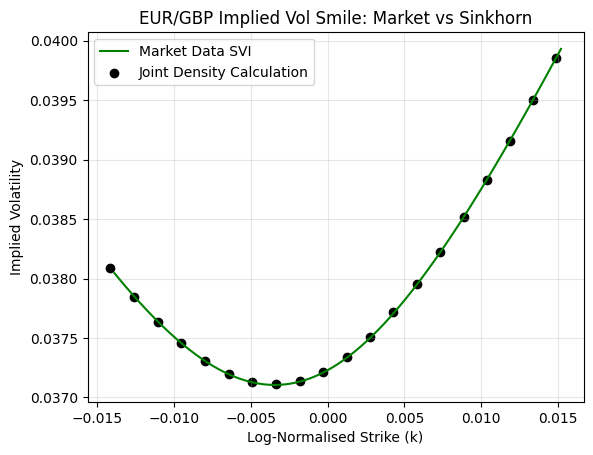

In [25]:
def test_density_on_Z(Z_norm, Z_forw, T, joint_density, weights_2d, Z_strikes_lognrm, Zopt, z_option_payoff):
    k_test = np.linspace(Z_norm[0], Z_norm[-1], 20)
    z_density_test_vol = np.zeros(len(k_test))
    for i in range(len(k_test)):
        payoff_vals = z_option_payoff(X, Y, k_test[i])
        price = np.sum(payoff_vals * joint_density * weights_2d) * Z_forw
        z_density_test_vol[i] = bs_lib.implied_vol(Z_forw, k_test[i] * Z_forw, T, price)
    # Vectorized payoff function
    Z_strike_range = np.linspace(0.98 * min(Z_strikes_lognrm), 1.02 * max(Z_strikes_lognrm), 1000)
    svi_vol_line = svi_lib.svi_vol(Z_strike_range, Zopt.x, T)
    # Plotting
    plt.plot(Z_strike_range, svi_vol_line, color="green", label="Market Data SVI")
    scatter_points = plt.scatter(np.log(k_test), z_density_test_vol, color="black", label="Joint Density Calculation")
    plt.xlabel('Log-Normalised Strike (k)')
    plt.ylabel('Implied Volatility')
    plt.title('EUR/GBP Implied Vol Smile: Market vs Sinkhorn')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    # Test for deviation
    line_values_at_scatter = np.interp(np.log(k_test), Z_strike_range, svi_vol_line)
    deviations = np.abs(z_density_test_vol - line_values_at_scatter)
    threshold = 1e-4
    assert np.all(deviations < threshold)

test_density_on_Z(Z_norm, Z_forw, T, joint_density, weights_2d, Z_strikes_lognrm, Zopt, z_option_payoff)

### Computations of Exotics

In [47]:
basket_price= np.sum(basket_payoff(X,Y,1) * joint_density * weights_2d)
quanto_price=np.sum(quanto_payoff(X,Y,1) * joint_density * weights_2d)
best_of_price=np.sum(best_of_payoff(X,Y,1) * joint_density * weights_2d)
quadratic_price=np.sum(quadratic_payoff(X,Y,0) * joint_density * weights_2d)

print(f"{'Payoff Type':<25}{'Price':>15}")
print("-" * 40)
print(f"{'Basket option (k=1)':<25}{basket_price:>15.6f}")
print(f"{'Quanto option (k=1)':<25}{quanto_price:>15.6f}")
print(f"{'Best-of option':<25}{best_of_price:>15.6f}")
print(f"{'Quadratic payoff':<25}{quadratic_price:>15.6f}")


Payoff Type                        Price
----------------------------------------
Basket option (k=1)             0.005886
Quanto option (k=1)             0.004331
Best-of option                  0.008431
Quadratic payoff                0.000122


# Part 3: Robust Price Bounds with Linear Programming

### Probability Mass Function grid

In [52]:
"""Dimnsions of the pmf"""
grid_size = 50
x_vals = np.linspace(0.8, 1.2, grid_size)
y_vals = np.linspace(0.8, 1.2, grid_size)
X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

derivatives = {
    "Basket": lambda x, y: np.maximum(0.5 * (x + y) - 1, 0),
    "Quanto": lambda x, y: np.maximum(x / y - 1, 0),
    "Best-Of": lambda x, y: np.maximum(np.maximum(x, y)-1,0),
    "Quadratic": lambda x, y: (x - y)**2,
}

sinkhorn_prices = {
    "Basket": basket_price,
    "Quanto": quanto_price,
    "Best-Of": best_of_price,
    "Quadratic": quadratic_price,
}

### Building the matrix of option price constraints for linear programming

In [53]:
"""Option Data constraints"""
x_strikes = X_norm
x_price = X_market_prices / X_forw
A_X = np.zeros((len(x_strikes), grid_size**2))
for k, K_x in enumerate(x_strikes):
    for i in range(grid_size):
        for j in range(grid_size):
            A_X[k, i * grid_size + j] = max(x_vals[i] - K_x, 0)

y_strikes = Y_norm
y_price = Y_market_prices / Y_forw
A_Y = np.zeros((len(y_strikes), grid_size**2))
for k, K_y in enumerate(y_strikes):
    for i in range(grid_size):
        for j in range(grid_size):
            A_Y[k, i * grid_size + j] = max(y_vals[j] - K_y, 0)

z_strikes = Z_norm
z_price = Z_market_prices / Z_forw
A_Z = np.zeros((len(z_strikes), grid_size**2))
for k, K_z in enumerate(z_strikes):
    for i in range(grid_size):
        for j in range(grid_size):
            A_Z[k, i * grid_size + j] = max(x_vals[i] - K_z * y_vals[j], 0)


"""forward constraints - (mostly for use in dual problem's hedging portfolio)"""
A_forwards = []
b_forwards = []

row_fX = np.zeros(grid_size**2)
for i in range(grid_size):
    for j in range(grid_size):
        row_fX[i * grid_size + j] = x_vals[i] - 1.0  # correct shape and indexing
A_forwards.append(row_fX)
b_forwards.append(0.0)

row_fY = np.zeros(grid_size**2)
for i in range(grid_size):
    for j in range(grid_size):
        row_fY[i * grid_size + j] = y_vals[j] - 1.0  # correct shape and indexing
A_forwards.append(row_fY)
b_forwards.append(0.0)

A_forwards = np.vstack(A_forwards)      
b_forwards = np.array(b_forwards)

A_norm=np.ones((1,grid_size**2))
b_norm=np.array([1.0])

"""Matrix for primal problem"""
A_eq = np.vstack([A_X, A_Y, A_Z, A_norm, A_forwards])
b_eq = np.concatenate([x_price, y_price, z_price, b_norm, b_forwards])
bounds = [(0, None)] * (grid_size**2)

"""DUAL PROBLEM"""
row_fX = np.zeros(grid_size**2)
row_fY = np.zeros(grid_size**2)
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        row_fX[idx] = x_vals[i]
        row_fY[idx] = y_vals[j]

A_dual = np.hstack([
    A_X.T,
    A_Y.T,
    A_Z.T,
    row_fX[:, None],
    row_fY[:, None]
])
b_dual = np.concatenate([x_price, y_price, z_price, np.array([1.0]), np.array([1.0])])


### Bounding each Sinkhorn price

In [54]:
print(f"{'Derivative':<12} {'Min Price':>12} {'Sinkhorn':>12} {'Max Price':>12}")
print("-" * 50)

for name, payoff_fn in derivatives.items():
    payoff_grid = payoff_fn(X, Y)
    payoff_flat = payoff_grid.flatten()

    res_min = linprog(
        c=payoff_flat,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        method="highs"
    )
    min_price = res_min.fun if res_min.success else np.nan

    res_max = linprog(
        c=-payoff_flat,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        method="highs"
    )
    max_price = -res_max.fun if res_max.success else np.nan

    sinkhorn_price = sinkhorn_prices.get(name, np.nan)
    
    print(f"{name:<12} {min_price:12.6f} {sinkhorn_price:12.6f} {max_price:12.6f}")



Derivative      Min Price     Sinkhorn    Max Price
--------------------------------------------------
Basket           0.004736     0.005886     0.006286
Quanto           0.004256     0.004331     0.004439
Best-Of          0.006996     0.008431     0.009857
Quadratic        0.000121     0.000122     0.000374


### Plot of bounds against strike for basket and quanto options

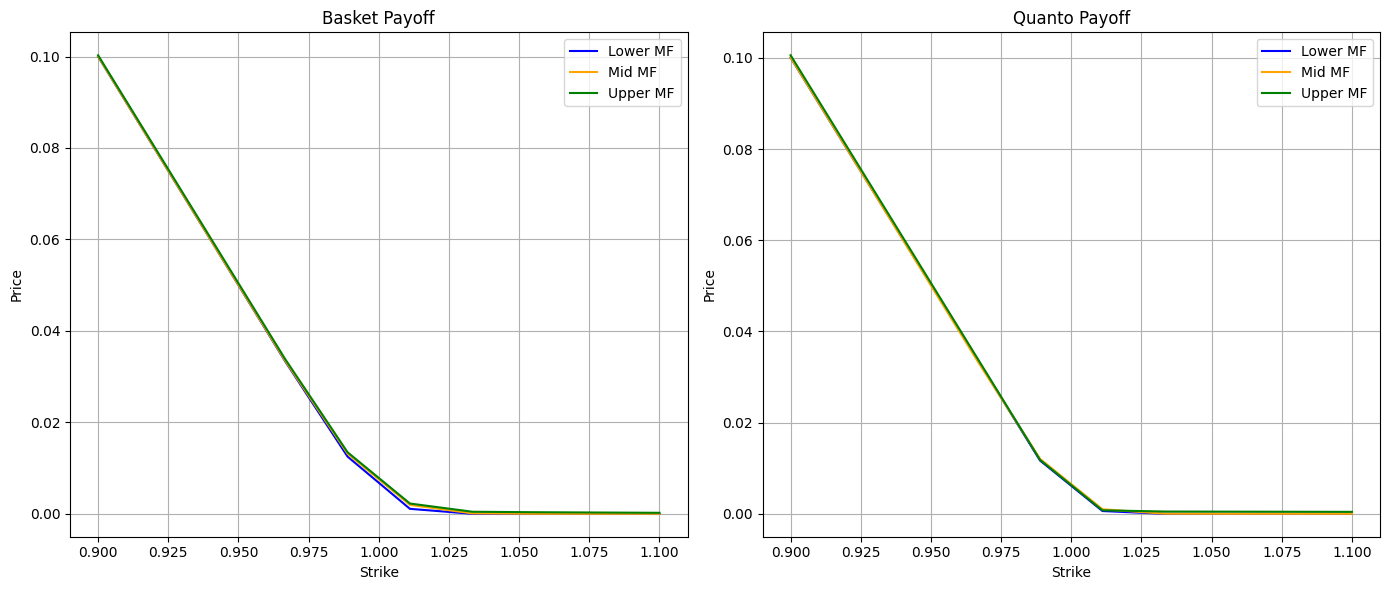

In [221]:
plot_strikes=np.linspace(0.9,1.1,10)
def strike_vs_bounds(plot_strikes, basket_payoff, quanto_payoff, A_eq, b_eq, bounds, quadgrid, quadweights, joint_density):
    basket_lower_MF = []
    basket_mid_MF = []
    basket_upper_MF = []

    quanto_lower_MF = []
    quanto_mid_MF = []
    quanto_upper_MF = []

    for pk in plot_strikes:
        # Basket computations
        payoff_grid = basket_payoff(X, Y, pk)
        payoff_flat = payoff_grid.flatten()
        res_min = linprog(c=payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        min_price = res_min.fun if res_min.success else np.nan
        basket_lower_MF.append(min_price)

        pX, pY = np.meshgrid(quadgrid, quadgrid)
        weights_2d = quadweights[:, np.newaxis] * quadweights[np.newaxis, :]
        basket_price = np.sum(basket_payoff(pX, pY, pk) * joint_density * weights_2d)
        basket_mid_MF.append(basket_price)

        res_max = linprog(c=-payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        max_price = -res_max.fun if res_max.success else np.nan
        basket_upper_MF.append(max_price)

        # Quanto computations
        payoff_grid = quanto_payoff(X, Y, pk)
        payoff_flat = payoff_grid.flatten()
        res_min = linprog(c=payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        min_price = res_min.fun if res_min.success else np.nan
        quanto_lower_MF.append(min_price)

        quanto_price = np.sum(quanto_payoff(pX, pY, pk) * joint_density * weights_2d)
        quanto_mid_MF.append(quanto_price)

        res_max = linprog(c=-payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        max_price = -res_max.fun if res_max.success else np.nan
        quanto_upper_MF.append(max_price)


    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(plot_strikes, basket_lower_MF, label='Lower MF', color='blue')
    axes[0].plot(plot_strikes, basket_mid_MF, label='Mid MF', color='orange')
    axes[0].plot(plot_strikes, basket_upper_MF, label='Upper MF', color='green')
    axes[0].set_title('Basket Payoff')
    axes[0].set_xlabel('Strike')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(plot_strikes, quanto_lower_MF, label='Lower MF', color='blue')
    axes[1].plot(plot_strikes, quanto_mid_MF, label='Mid MF', color='orange')
    axes[1].plot(plot_strikes, quanto_upper_MF, label='Upper MF', color='green')
    axes[1].set_title('Quanto Payoff')
    axes[1].set_xlabel('Strike')
    axes[1].set_ylabel('Price')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

"""Low resolution demo version of the bounds on sinkhorn prices plotted below

Higher resolution plots can be loaded from pre computed files: "quanto_50strikes_bounds.txt" & "basket_50strikes_bounds.txt"
"""
strike_vs_bounds(plot_strikes, basket_payoff, quanto_payoff, A_eq, b_eq, bounds, quadgrid, quadweights, joint_density)

### The super and sub hedging portfolio
Restrict our attention to an at the money basket option - will solve the primal and dual primal to give the price bounds and corresponding hedging portfolio respectively.

In [42]:
#payoff function
def payoff_general(X, Y, K=None):
    return np.maximum((X-Y)**2, 0)

K=1
payoff_grid = payoff_general(X, Y, K)
payoff_flat = payoff_grid.flatten()

#primal upper
res_min = linprog(c=payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
min_price = res_min.fun if res_min.success else np.nan

#primal lower
res_max = linprog(c=-payoff_flat, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
max_price = -res_max.fun if res_max.success else np.nan

#sinkhorn price
pX, pY = np.meshgrid(quadgrid, quadgrid)
weights_2d = quadweights[:, np.newaxis] * quadweights[np.newaxis, :]
sinkhorn_price = np.sum(payoff_general(pX, pY,K) * joint_density * weights_2d)

#dual upper
res_dual_super = linprog(
    c=b_dual,            
    A_ub=-A_dual,       
    b_ub=-payoff_flat,   
    bounds=[(None, None)] * A_dual.shape[1],  
    method='highs'
)
hedge_price_super=res_dual_super.fun
weights_super = res_dual_super.x

#dual lower
res_dual_sub = linprog(
    c=-b_dual,            
    A_ub=A_dual,          
    b_ub=payoff_flat,      
    bounds=[(None, None)] * A_dual.shape[1], 
    method='highs'
)
hedge_price_sub=-res_dual_sub.fun
weights_sub = res_dual_sub.x

n_X = len(X_norm)
n_Y = len(Y_norm)
n_Z = len(Z_norm)

weights_X_super = weights_super[:n_X]
weights_Y_super = weights_super[n_X:n_X + n_Y]
weights_Z_super = weights_super[n_X + n_Y:n_X + n_Y + n_Z]
weight_fX_super = weights_super[n_X + n_Y + n_Z]
weight_fY_super = weights_super[-1]

weights_X_sub = weights_sub[:n_X]
weights_Y_sub = weights_sub[n_X:n_X + n_Y]
weights_Z_sub = weights_sub[n_X + n_Y:n_X + n_Y + n_Z]
weight_fX_sub = weights_sub[n_X + n_Y + n_Z]
weight_fY_sub = weights_sub[-1]

# Calculate hedge grids for super and sub hedges
hedge_flat_super = A_dual @ weights_super
hedge_grid_super = hedge_flat_super.reshape(grid_size, grid_size)
diff_super = hedge_grid_super - payoff_grid
hedge_flat_sub = A_dual @ weights_sub
hedge_grid_sub = hedge_flat_sub.reshape(grid_size, grid_size)

# Compute differences
diff_super = hedge_grid_super - payoff_grid
diff_sub = hedge_grid_sub - payoff_grid

# Duality gap
upper_duality_gap = max_price - hedge_price_super
lower_duality_gap = min_price-hedge_price_sub  



In [44]:

table = [
    ["Upper Bound", max_price],
    ["Sinkhorn Price", sinkhorn_price],
    ["Lower Bound", min_price],
    ["Upper Duality Gap", upper_duality_gap],
    ["Lower Duality Gap", lower_duality_gap]
]
print(tabulate(table, headers=["Quantity", "Value"], floatfmt=".6f"))


Quantity              Value
-----------------  --------
Upper Bound        0.000514
Sinkhorn Price     0.000122
Lower Bound        0.000112
Upper Duality Gap  0.000000
Lower Duality Gap  0.000010


In [246]:

def plot_superhedge_composition(weights_X, weights_Y, weights_Z,forwards_weights,strikes_X, strikes_Y, strikes_Z,width=0.1):
    weight_fX, weight_fY = forwards_weights

    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    max_weight = max(
        np.max(np.abs(weights_X)),
        np.max(np.abs(weights_Y)),
        np.max(np.abs(weights_Z))
    )

    # Plot X vanilla calls
    axs[0].bar(np.arange(len(weights_X)), weights_X / max_weight, width=width)
    axs[0].set_title(f"X vanilla calls\nForward weight: {weight_fX:.4f}")
    axs[0].set_xticks(np.arange(len(strikes_X)))
    axs[0].set_xticklabels([f"{k:.3f}" for k in strikes_X], rotation=45)
    axs[0].set_xlabel("Strike")
    axs[0].set_ylabel("Normalized Weight")

    # Plot Y vanilla calls
    axs[1].bar(np.arange(len(weights_Y)), weights_Y / max_weight, width=width, color='orange')
    axs[1].set_title(f"Y vanilla calls\nForward weight: {weight_fY:.4f}")
    axs[1].set_xticks(np.arange(len(strikes_Y)))
    axs[1].set_xticklabels([f"{k:.3f}" for k in strikes_Y], rotation=45)
    axs[1].set_xlabel("Strike")

    # Plot Z vanilla calls
    axs[2].bar(np.arange(len(weights_Z)), weights_Z / max_weight, width=width, color='green')
    axs[2].set_title(f"Z vanilla calls\nCash weight: {weight_cash_super:.4f}")
    axs[2].set_xticks(np.arange(len(strikes_Z)))
    axs[2].set_xticklabels([f"{k:.3f}" for k in strikes_Z], rotation=45)
    axs[2].set_xlabel("Strike")

    plt.tight_layout()
    plt.show()

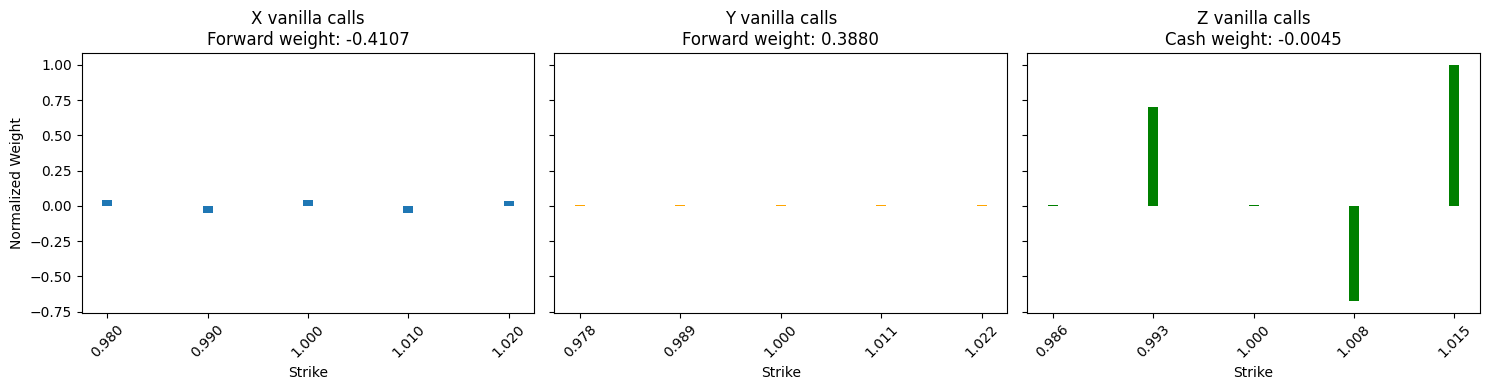

In [247]:
plot_superhedge_composition(weights_X_super, weights_Y_super, weights_Z_super,(weight_fX_super, weight_fY_super),X_norm, Y_norm, Z_norm)

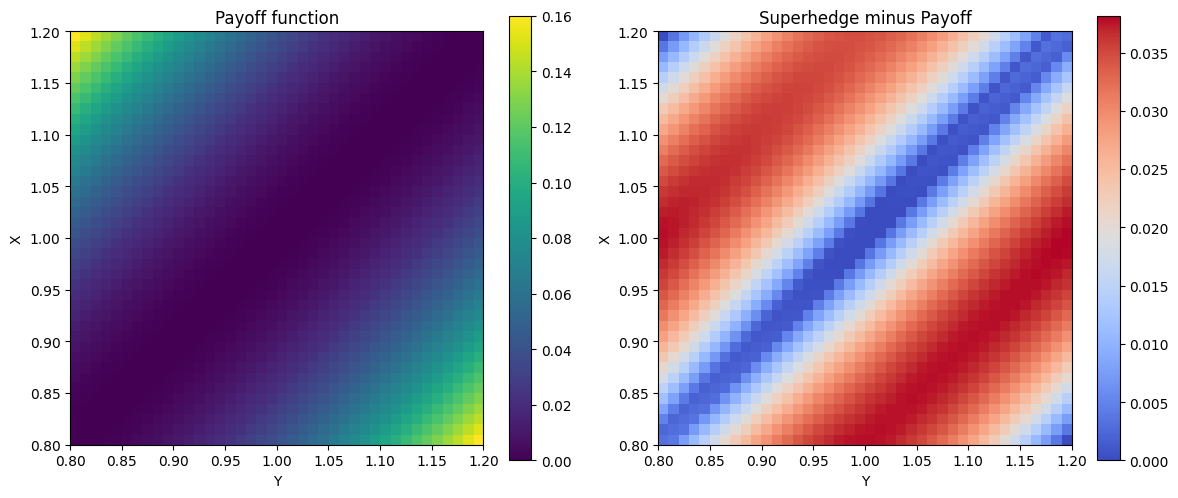

In [248]:
def plot_payoff_and_diff(X, Y, payoff_grid, hedge_grid_super):
    diff = hedge_grid_super - payoff_grid

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(payoff_grid, extent=[Y.min(), Y.max(), X.min(), X.max()],
                        origin='lower', aspect='equal', cmap='viridis')
    axs[0].set_title("Payoff function")
    axs[0].set_xlabel("Y")
    axs[0].set_ylabel("X")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(diff, extent=[Y.min(), Y.max(), X.min(), X.max()],
                        origin='lower', aspect='equal', cmap='coolwarm')
    axs[1].set_title("Superhedge minus Payoff")
    axs[1].set_xlabel("Y")
    axs[1].set_ylabel("X")
    fig.colorbar(im1, ax=axs[1])

    plt.tight_layout()
    plt.show()
plot_payoff_and_diff(X, Y, payoff_grid, hedge_grid_super)